# Optimize process

Here we simultaneously explore the audio loading and the parallelization problem.

## Input dataframe

In [15]:
from pandas import read_csv

In [ ]:
df = read_csv("test_input.csv")
df.head()
df = df.head() # TODO: remove this line to test the whole set

## Auxiliary functions: `filename_from_*`
This adapter will help us converting our syntax (using keys and rows) into librosa's syntax (using filenames).

In [17]:
def filename_from_key(key, data_folder = "data", ext = ".wav"):
    """ Takes the key, returns the filename """
    return data_folder + key + ext #TODO: consider improving this using os.path

def filename_from_row(row, data_folder = "data", ext = ".wav"):
    """ Takes the row, returns the filename """
    return filename_from_key(row["key"], data_folder, ext)

### Examples

In [18]:
filename_from_key("/catalan1/ca_f02a_m05a_und")

'data/catalan1/ca_f02a_m05a_und.wav'

In [19]:
filename_from_row(df.iloc[0, ])

'data/german1/5298.wav'

## Extract audio features

In [20]:
import librosa

In [21]:
def audio_from_key(key, **kwargs):
    """ Equivalent to librosa.core.load, but works with keys instead of with filenames """
    return librosa.core.load(filename_from_key(key), **kwargs)

def audio_from_row(row, **kwargs):
    """ Equivalent to librosa.core.load, but works with rows instead of with filenames """
    return librosa.core.load(filename_from_row(row, **kwargs))

### Example of usage

In [22]:
data, rate = audio_from_key("/catalan1/ca_f02a_m05a_und")
print(data)
print(rate)

[-1.6827690e-03 -2.3811827e-03 -2.2289073e-03 ... -1.8447537e-08
 -9.6680355e-07  0.0000000e+00]
22050


In [23]:
data, rate = audio_from_row(df.iloc[0, ])
print(data)
print(rate)

[-0.00043917 -0.00046311 -0.00031764 ... -0.00100527 -0.00074906
 -0.00034924]
22050


## Compare performances using keys

In [24]:
import dask.bag as db

### Serial

In [25]:
for row in df["key"]:
    print(row)
    data, rate = audio_from_key(row)
    print(rate)

/german1/5298
22050
/german1/5298
22050
/sambas1/SBS-20111031
22050
/sambas1/SBS-20111031
22050
/german1/4123
22050


### Parallel

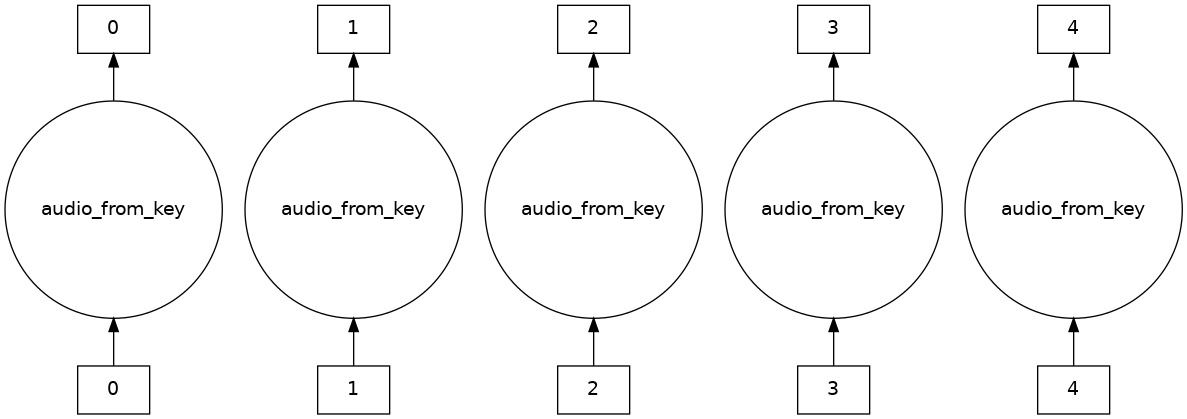

In [26]:
bag = db.from_sequence(df["key"])
bag.map(audio_from_key).visualize()

In [27]:
bag.map(audio_from_key).compute()

[(array([-0.00043917, -0.00046311, -0.00031764, ..., -0.00100527,
         -0.00074906, -0.00034924], dtype=float32),
  22050),
 (array([-0.00043917, -0.00046311, -0.00031764, ..., -0.00100527,
         -0.00074906, -0.00034924], dtype=float32),
  22050),
 (array([-0.00298155, -0.00379412, -0.00346273, ...,  0.00318763,
          0.00121096,  0.        ], dtype=float32),
  22050),
 (array([-0.00298155, -0.00379412, -0.00346273, ...,  0.00318763,
          0.00121096,  0.        ], dtype=float32),
  22050),
 (array([-0.00047702, -0.00061028, -0.00054473, ...,  0.11889616,
          0.07809759,  0.0338393 ], dtype=float32),
  22050)]

## Compare performances using rows

In [28]:
for _, row in df.iterrows():
    print(row)
    data, rate = audio_from_row(row)
    print(rate)

start_time                    629.96
end_time                      630.51
participant                        A
utterance                        aha
key                    /german1/5298
language                      german
uid            german-059-255-629960
Name: 0, dtype: object
22050
start_time                    398.87
end_time                      399.33
participant                        A
utterance                        aha
key                    /german1/5298
language                      german
uid            german-059-151-398870
Name: 1, dtype: object
22050
start_time                     2009.1
end_time                       2009.5
participant                 tx@ADUSBS
utterance                         aoq
key             /sambas1/SBS-20111031
language                       sambas
uid            sambas-24-0883-2009100
Name: 2, dtype: object
22050
start_time                    1782.89
end_time                       1783.4
participant                 tx@JEPSBS
utterance      

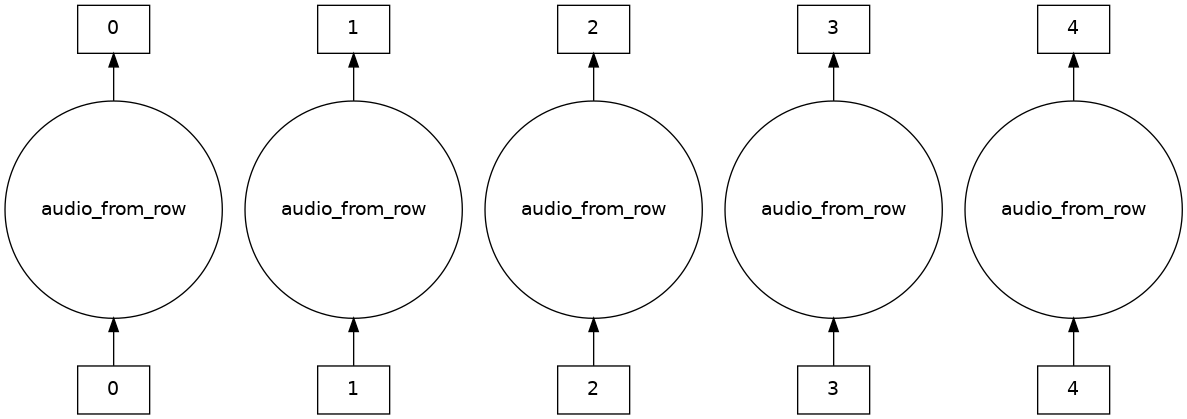

In [29]:
bag = db.from_sequence(df.iterrows())
bag.map(audio_from_row).visualize()

In [30]:
# bag.map(audio_from_row).compute() # TODO: figure out why this fails

## Compare performance using Dask dataframes

In [31]:
import dask.dataframe as dd
df_opt = dd.from_pandas(df, npartitions=8)


In [32]:
# df_opt.apply(audio_from_row, axis=1).compute() # TODO: figure out why this fails